In [1]:
import numpy

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
})

In [4]:
from numpy.random import default_rng
rng = default_rng()
samples = sorted(filter(lambda x: x >= 0 and x <= 1.0, rng.standard_normal(100)))

<BarContainer object of 35 artists>

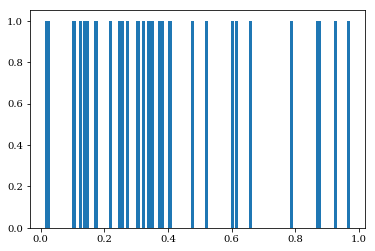

In [5]:
plt.bar(samples, 1.0, 0.01)

In [6]:
def gaussian(x):
    return 1/numpy.sqrt(2*numpy.pi)*numpy.exp(-0.5*x**2.0)

from scipy.special import erf

def gaussian_cdf(x):
    return 0.5*(1.0+erf(x*2**-0.5))

7.35807440813778 1.0000000518694219


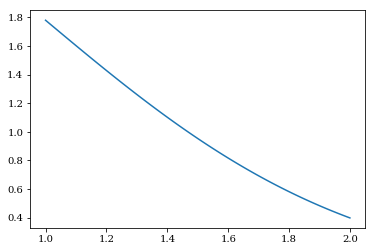

In [7]:
def gaussian_scaling(a, b):
    return -2.0/(erf(a*2**-0.5)+erf(-b*2**-0.5))

a,b = (1,2)
kx = numpy.linspace(a, b, 100)
scaling = gaussian_scaling(a,b)
ky = scaling*gaussian(kx)
plt.plot(kx,ky)
from scipy.integrate import simps

print(scaling, simps(ky, kx))

In [8]:
1/2 * ( 1 + erf(0))

0.5

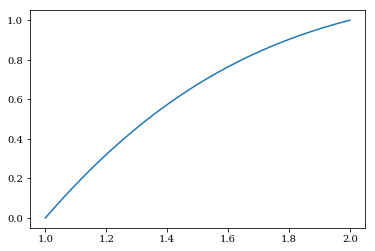

In [9]:
ky = scaling*(gaussian_cdf(kx)-gaussian_cdf(1))
plt.plot(kx,ky)

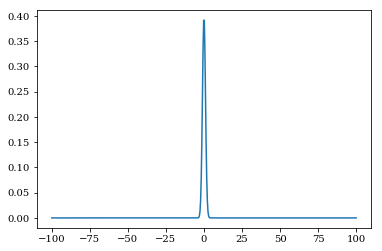

In [10]:
kx = numpy.linspace(-100,100, 500) 
plt.plot(kx,gaussian(kx))

In [11]:
simps(gaussian(kx), kx)

0.9999999999999999

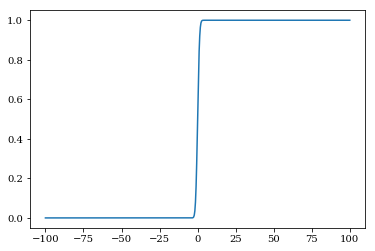

In [12]:
plt.plot(kx,gaussian_cdf(kx))

In [13]:
def epanechnikov(x):
    return 0.75*numpy.maximum(1.0-x*x, 0)

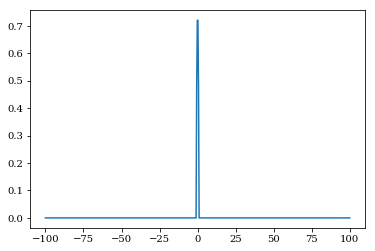

In [14]:
plt.plot(kx,epanechnikov(kx))

In [15]:
def bump(r):
    return numpy.where(numpy.fabs(r) <= 1.0, numpy.where(numpy.fabs(1-r**2.0) < 1e-6, numpy.exp(-1), numpy.exp(-1.0/(1.0-r**2.0))),0.0)

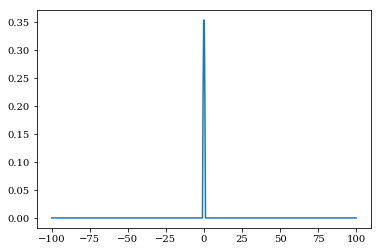

In [16]:
plt.plot(kx,bump(kx))

In [17]:
def bw_estimate(samples):
    sigma = numpy.std(samples)
    return ((4*sigma**5.0)/(3.0*len(samples)))**(1.0/5.0)

In [18]:
#def kde(x, samples, hfunc, kernel=bump):
def kde(x, samples, hfunc, kernel=gaussian, integral=False):
#def kde(x, samples, hfunc, kernel=epanechnikov):
    f_y = numpy.zeros(len(x))
    lim = (x[0], x[-1])
    for sx in samples:
        assert sx >= lim[0] and sx <= lim[1]
            
        loc_h = hfunc(sx)
        scaling = gaussian_scaling((lim[0]-sx)/loc_h,(lim[1]-sx)/loc_h)
        if not integral:
            f_y += 1.0/loc_h * scaling * kernel((x-sx)/loc_h)
        else:
            f_y +=  scaling * ( kernel((x-sx)/loc_h)-kernel((lim[0]-sx)/loc_h))
    res = f_y/len(samples)
    return res

0.9999999998388834


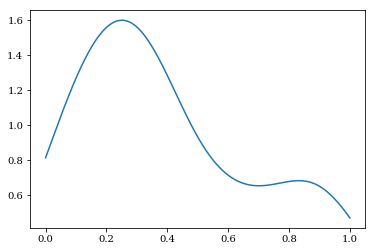

In [19]:
import numpy
bw0 = bw_estimate(samples)
x = numpy.linspace(0, 1, 1000)
f_y = kde(x, samples, lambda _: bw0)
plt.plot(x, f_y)
print(simps(f_y,x))

0.9026927510426752


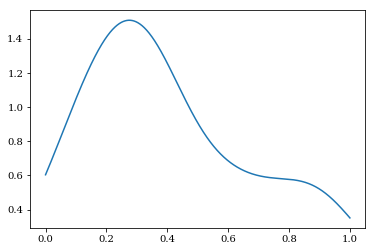

In [20]:
import scipy.stats
f_y_scipy = scipy.stats.gaussian_kde(samples)
plt.plot(x, f_y_scipy(x))
print(simps(f_y_scipy(x),x))

In [21]:
def lookup(lx, x, den, bw):
    assert len(den) == len(x)
    loc = numpy.searchsorted(x, lx)
    if loc >= len(den):
        lookup = den[-1]
    else:
        lookup = den[loc]
    return bw * lookup**-0.5 

In [22]:
def reflect(samples):
    d = sorted(samples)
    n = len(d)
    cutlow = 0
    for i in range(n):
        if d[i] != d[0]:
            cutlow = i
            break
    cuthigh = 0
    for i in range(n):
        if d[n-1-i] != d[-1]:
            cuthigh = n-i
            break
    return [d[0] - x for x in reversed(d[cutlow:])] + d + [d[-1] + x for x in reversed(d[:cuthigh])]      

In [23]:
def akde(samples, lim=10, bw0=None, bwmul=1.0, xlim=None, kernel=gaussian, integral=False):
    if xlim == None:
        xlim=(samples[0],samples[-1])
    if bw0 == None:
        bw0 = bw_estimate(samples)
        print(bw0)
    x = numpy.linspace(xlim[0], xlim[-1], 1000)
    fs  =[kde(x, samples, lambda _: bw0, kernel=kernel, integral=integral)]
    for i in range(lim):
        fs.append(kde(x, samples, lambda lx: lookup(lx, x, fs[-1], bwmul), kernel=kernel, integral=integral))  
    return x, fs

0.14035529090423668


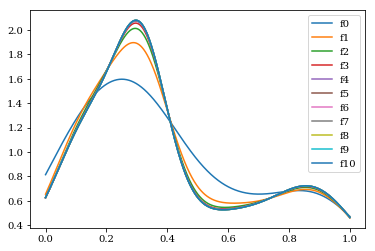

In [24]:
x, fs = akde(samples, bwmul=0.1, xlim=[0,1])
for i, p in enumerate(fs):
    if 1:#i == len(fs)-1:
        plt.plot(x, p, label=f"f{i}")
plt.legend(loc='best')

0.14035529090423668


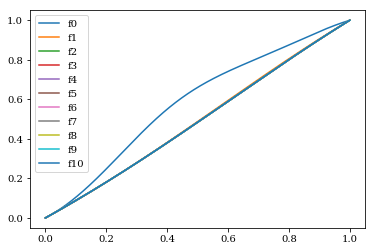

In [25]:
x, fs = akde(samples, bwmul=0.5, xlim=[0,1], kernel=gaussian_cdf, integral=True)
for i, p in enumerate(fs):
    if 1:#i == len(fs)-1:
        plt.plot(x, p, label=f"f{i}")
plt.legend(loc='best')

In [26]:
import pp_util
import importlib
importlib.reload(pp_util)

<module 'pp_util' from '/home/jsewall/misc/pp/2020/metrics/scripts/pp_util.py'>

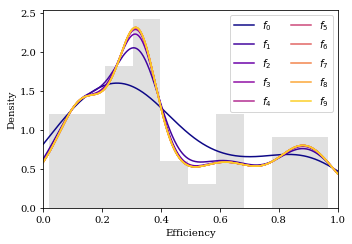

In [96]:
fig=plt.figure(figsize=(5.0,3.5))
test_akde = pp_util.akde(numpy.linspace(0,1,500), samples, 0.075)
fys = test_akde.pdf_series(10)
cm = plt.get_cmap("plasma")
ax = fig.add_subplot(1,1,1)
ax.hist(samples,density=True, color="#e0e0e0", alpha=1.0, rwidth=1.0)
#ax2 = plt.twinx()
ax.set_ylabel("Density")
ax.set_xlabel("Efficiency")
ax.set_xlim([0,1])
for i, p in enumerate(fys):
    if 1:#i == len(fs)-1:
        ax.plot(test_akde.x, p, label=f"$f_{i}$", c=cm(i/10.0))
ax.legend(loc='best',ncol=2)
plt.tight_layout()
plt.savefig("../../images/kde-progression.pdf", bbox_inches="tight")

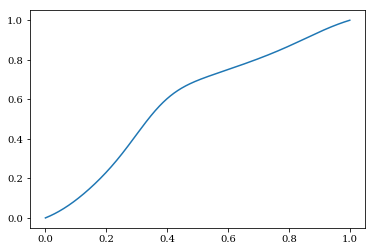

In [28]:
cdf = test_akde.cdf()
plt.plot(test_akde.x,cdf)

In [29]:
import os
qual_colormap = plt.get_cmap("tab10")
plat_order=["OpenMP", "Kokkos", "CUDA", "OpenACC", "OpenCL"]
csv_root = "../data/"

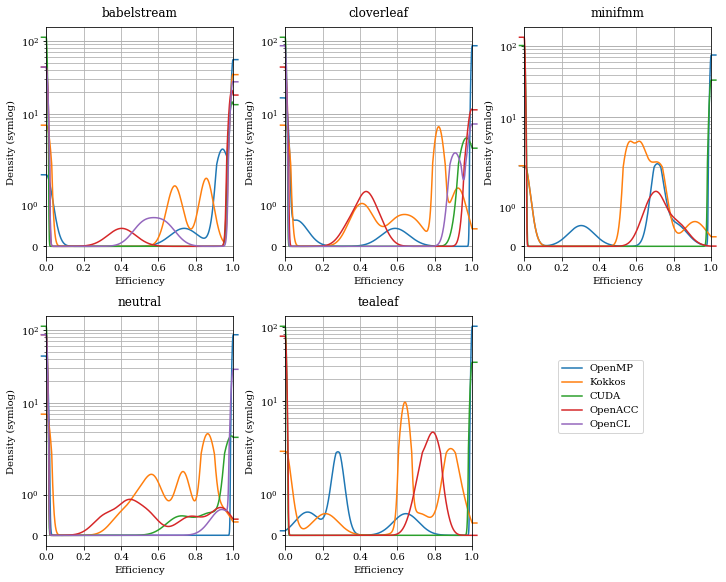

In [48]:
fig = plt.figure(figsize=(10, 8))
handles = {}
for i, fi in enumerate(["babelstream.csv", "cloverleaf.csv", "minifmm.csv", "neutral.csv", "tealeaf.csv"]):
    ax = fig.add_subplot(2,3,i+1)
    app_eff = pp_util.get_effs(os.path.join(csv_root,fi), throughput=(i==0))
    for idx, name in enumerate(plat_order):
        if name not in app_eff:
            continue
        data  = app_eff[name]
        d = sorted(data)
        l_akde = pp_util.akde(numpy.linspace(0,1,1000), d, 0.05)
        fs = l_akde.pdf_refine(10)
        extended_x = [-0.025] + list(l_akde.x) + [1.025]
        extended_y = [fs[0]] + list(fs) + [fs[-1]]
        h = ax.plot(extended_x,extended_y,label=name, color=qual_colormap(idx),clip_on=False)[0]
        if name not in handles:
            handles[name] = h
    plt.yscale('symlog', subsy=range(10))
    plt.grid(True)
    plt.xlim([0,1])
    ax.yaxis.grid(True, which='minor')
    ax.set_title(fi.split(".")[0],pad=10)
    plt.ylabel("Density (symlog)")
    plt.xlabel("Efficiency")
handles_names, handles_items = zip(*handles.items())
fig.legend(handles_items, handles_names, loc='lower right', bbox_to_anchor=(0.90,0.25))
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
fig.savefig(f"../../images/akde_apps.pdf", bbox_inches="tight") 
fig.savefig(f"../../images/akde_apps.pgf", bbox_inches="tight") 


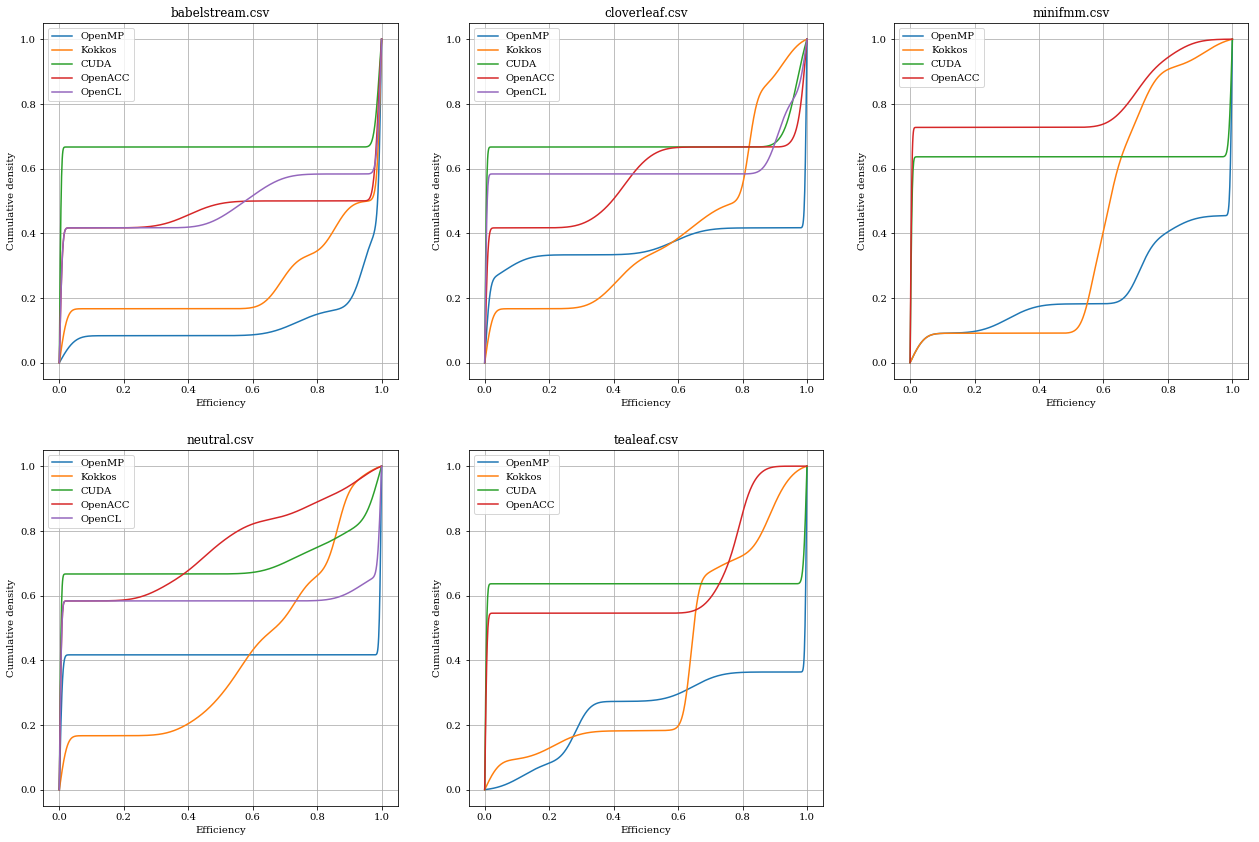

In [31]:
dpi = 150.0
fig = plt.figure(figsize=(3*1080/dpi, 2*1080/dpi))
for i, fi in enumerate(["babelstream.csv", "cloverleaf.csv", "minifmm.csv", "neutral.csv", "tealeaf.csv"]):
    ax = fig.add_subplot(2,3,i+1)
    app_eff = pp_util.get_effs(os.path.join(csv_root, fi), throughput=(i==0))
    for name, data in list(app_eff.items()):
        d = sorted(data)
        l_akde = pp_util.akde(numpy.linspace(0,1,1000), d, 0.05)
        fs = l_akde.pdf_refine(10)
        cdf = l_akde.cdf()
        ax.plot(x,cdf,label=name)
    plt.grid(True)
    ax.yaxis.grid(True, which='minor')
    ax.set_title(fi)
    ax.legend(loc='best')
    plt.ylabel("Cumulative density")
    plt.xlabel("Efficiency")
fig.savefig(f"../../images/akde_cdf_clipped_fixed.png", dpi=dpi) 

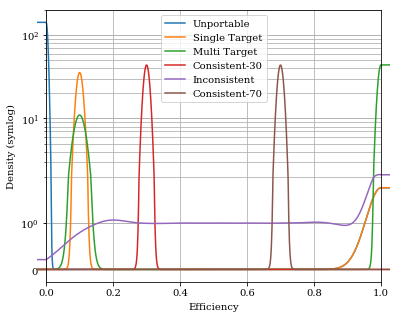

In [49]:
fig = plt.figure(figsize=(6, 5))
for i, fi in enumerate(["metrics_data_synthetic.csv"]):
    ax = fig.add_subplot(1,1,i+1)
    app_eff = pp_util.read_effs(os.path.join(csv_root, fi))
    for idx, (name, data) in enumerate(app_eff):
        d = sorted(data)
        l_akde = pp_util.akde(numpy.linspace(0,1,1000), d, 0.06)
        fs = l_akde.pdf_refine(10)
        extended_x = [-0.025] + list(l_akde.x) + [1.025]
        extended_y = [fs[0]] + list(fs) + [fs[-1]]
        h = ax.plot(extended_x,extended_y,label=name, color=qual_colormap(idx),clip_on=False)[0]
    plt.yscale('symlog', subsy=range(10))
    plt.grid(True)
    plt.xlim([0,1])
    ax.yaxis.grid(True, which='minor')
    ax.legend(loc='best')
    plt.ylabel("Density (symlog)")
    plt.xlabel("Efficiency")
fig.savefig(f"../../images/akde_synthetic.pdf", bbox_inches='tight') 

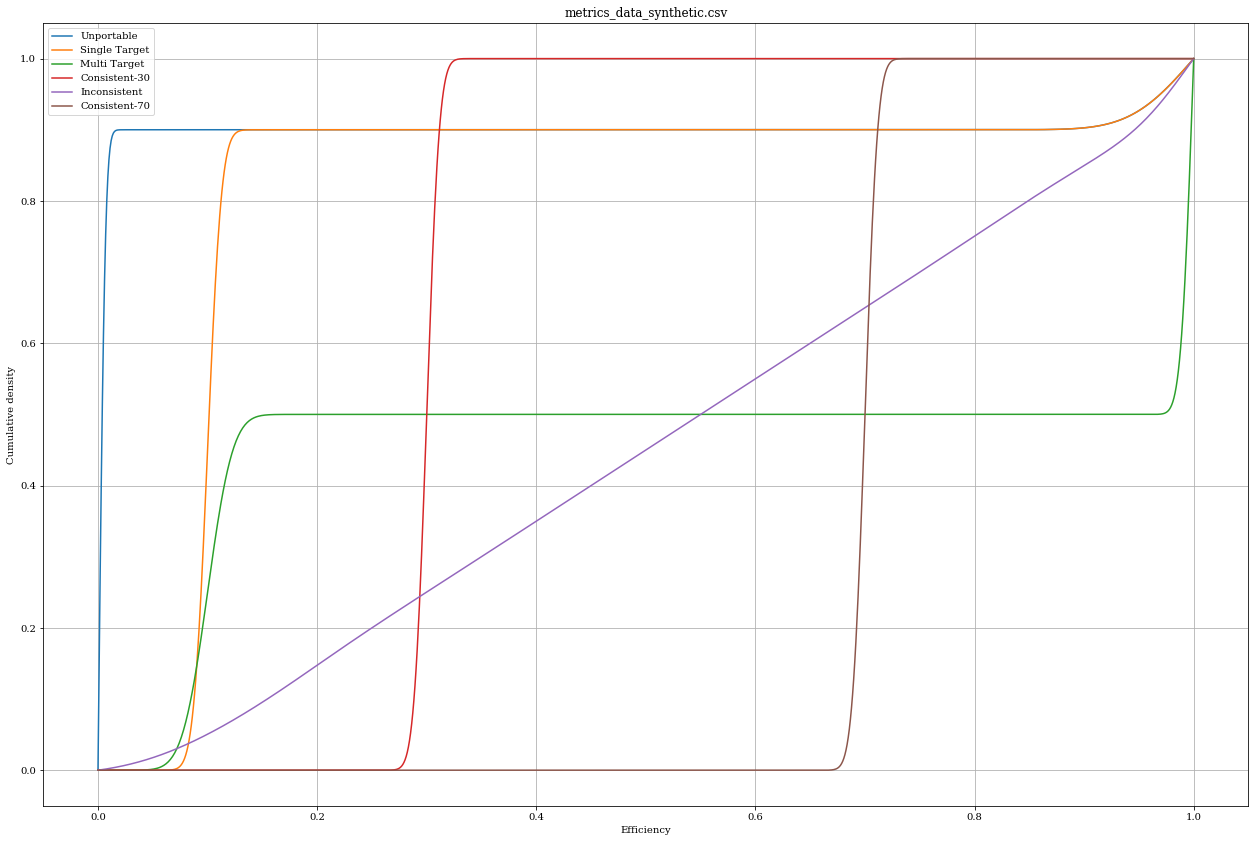

In [36]:
dpi = 150.0
fig = plt.figure(figsize=(3*1080/dpi, 2*1080/dpi))
for i, fi in enumerate(["metrics_data_synthetic.csv"]):
    ax = fig.add_subplot(1,1,i+1)
    app_eff = pp_util.read_effs(os.path.join(csv_root, fi))
    for name, data in app_eff:
        d = sorted(data)
        l_akde = pp_util.akde(numpy.linspace(0,1,1000), d, 0.06)
        fs = l_akde.pdf_refine(10)
        cdf = l_akde.cdf()
        ax.plot(x,cdf,label=name)
    plt.grid(True)
    ax.yaxis.grid(True, which='minor')
    ax.set_title(fi)
    ax.legend(loc='best')
    plt.ylabel("Cumulative density")
    plt.xlabel("Efficiency")
fig.savefig(f"../../images/akde_cdf_synthetic.png", dpi=dpi) 